[View in Colaboratory](https://colab.research.google.com/github/3catz/deeplearning_timeseries/blob/master/Eurasia_Air_Quality_Time_Series_Forecasting_with_(dilated)_convnets_and_EMD.ipynb)

# Eurasia Air Quality Time Series Analysis using EMD and Dilated Convnets (sometimes with Recurrent layers)


In [0]:
!pip install pyhht
!pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#import pandas_datareader.data as web
from pandas import Series
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer
import peakutils
#!pip install pyramid-arima
#from pyramid.arima import auto_arima

# Utilities: series to supervised, attention with context

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
   

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis = -1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]



# Loading Data 

In [5]:
from google.colab import files    
files.upload()




Saving CM_air.sig995.1948-2007.d.qs_eurasia.10_18.dat to CM_air.sig995.1948-2007.d.qs_eurasia.10_18.dat


{'CM_air.sig995.1948-2007.d.qs_eurasia.10_18.dat': b'246.4,245.47,242.57,241.67,243.75,248,247.22,245.78,247.9,258.87,258.3,252.6,246.28,244.87,245.32,246.75,244.07,243.15,257.65,247.8,247.1,255.67,259.17,257.02,253.4,243,243.8,247.75,258.02,257.62,253.03,239.05,232.2,241.2,236.03,235.5,240.53,239.75,245,246.6,249.72,246.9,250.2,245.67,247.9,250.3,247.8,263.02,265.52,241.12,238.82,241.62,236.87,230.45,232.75,235.57,240.4,223.62,214.03,214.04,224.17,223.47,227.6,228.67,229.32,231.6,233.12,234.9,228.53,229.32,240.5,235.32,230.54,233.35,232.65,252.94,255.97,267.42,263.6,261.15,259.17,255.84,252.28,254.29,252.17,249.97,249.53,244.12,244.1,246.28,249.82,249.55,255.72,258.17,255.99,248.07,240.2,245.4,245.9,246.35,245.5,246.85,242.5,256.67,269.82,270.65,265.87,262.65,258.1,255.04,256.05,258.87,260.92,257.3,254.25,252.75,252.42,256.62,255.72,256.95,263.9,270.02,268.35,264,270.39,269.45,263.5,259.22,267.27,271.49,272.22,267.64,270.12,271.05,273.32,271.75,269.77,269.12,271.47,272.95,274.07,273.6

In [7]:
import numpy as np  
data = np.fromfile("CM_air.sig995.1948-2007.d.qs_eurasia.10_18.dat", sep = ",")
print(data)
len(data)


[246.4  245.47 242.57 ... 251.18 242.98 236.15]


21915

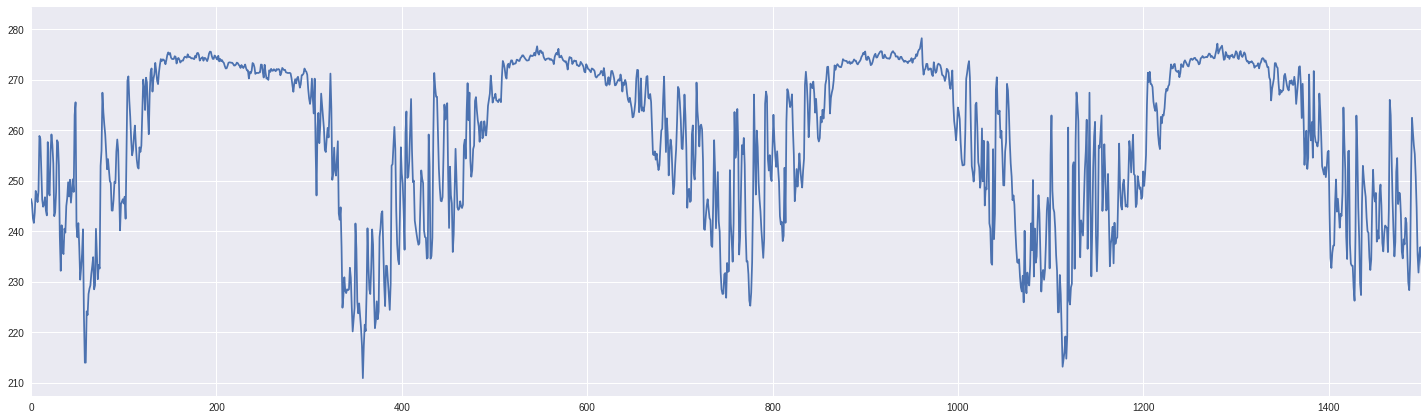

In [8]:
#Plot
from scipy.interpolate import interp1d 
plt.figure(figsize=(20,6))
plt.plot(data)
plt.tight_layout()
plt.xlim([0,1500])
plt.show()

In [9]:
print(np.min(data), np.max(data))


210.97 280.93


In [10]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(21915,)

In [0]:
scaled_data = np.transpose(scaled_data)

In [11]:
print(scaled_data.shape)

(21915,)


#Empirical Mode Decomposition


In [14]:
from pyhht.emd import EMD 
from pyhht.visualization import plot_imfs

decomposer1 = EMD(scaled_data,  maxiter = 10000)
imfs1 = decomposer1.decompose()
len(imfs1)

Mode 5, Iteration 3000
1 minima > 0; 980 maxima < 0.
Mode 5, Iteration 4000
3 minima > 0; 993 maxima < 0.
Mode 5, Iteration 5000
0 minima > 0; 1000 maxima < 0.


15

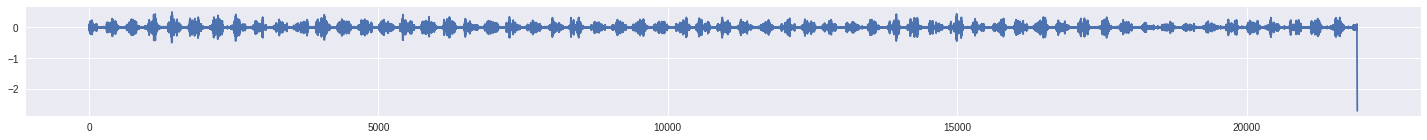

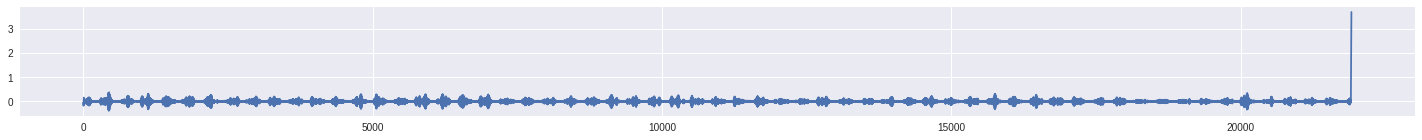

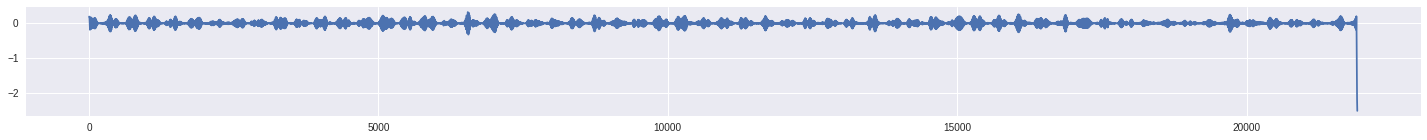

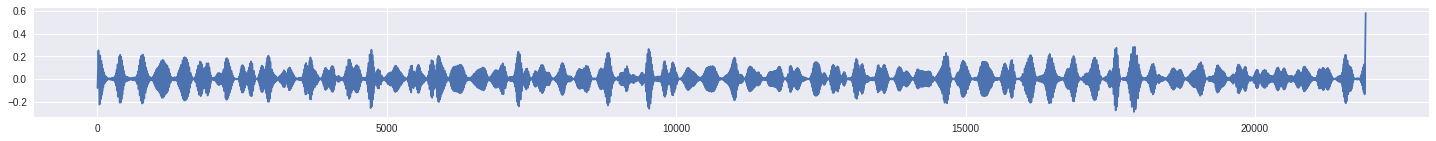

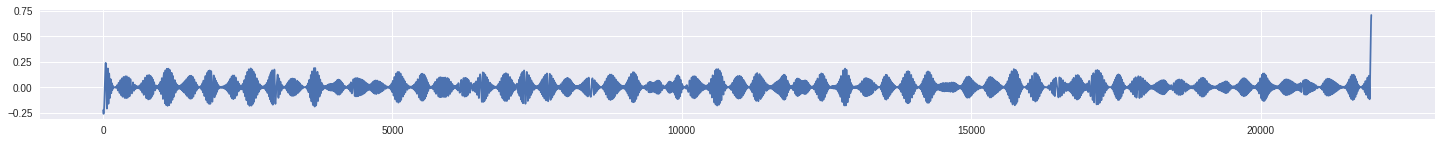

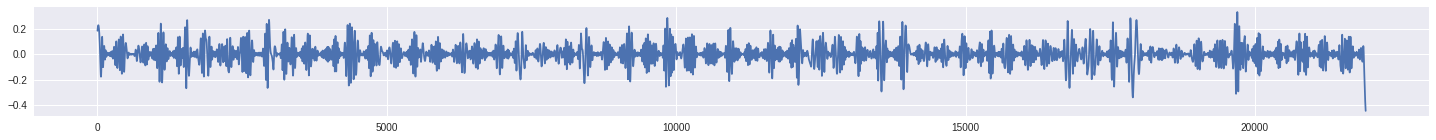

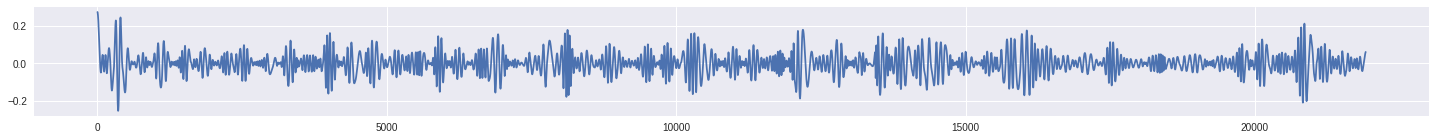

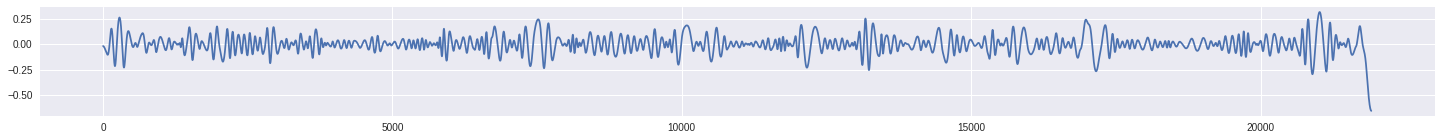

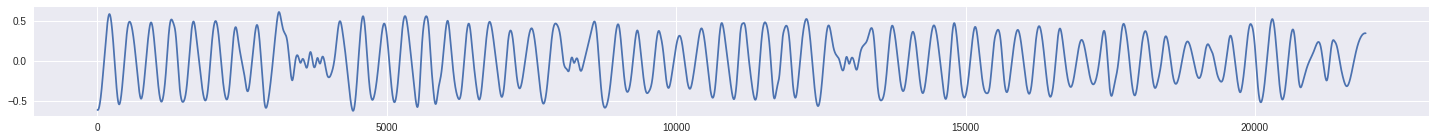

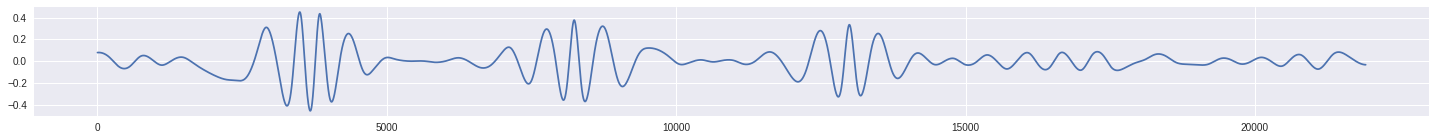

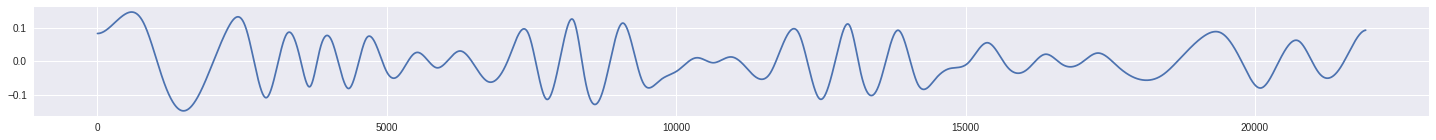

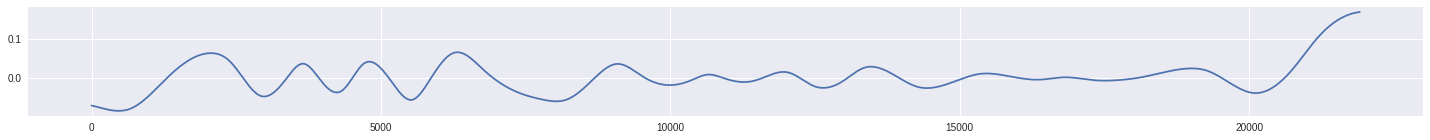

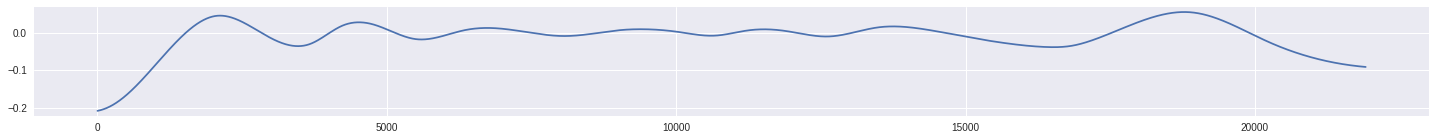

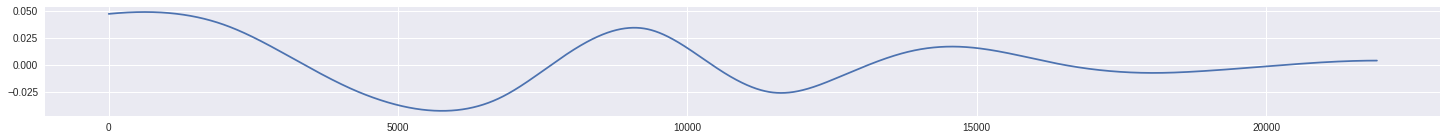

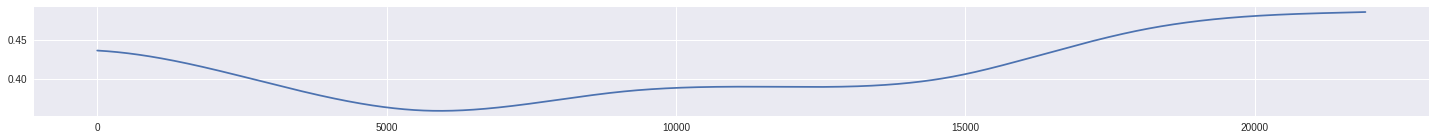

In [15]:
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(25,2))
  fig = plt.plot(imfs1[i])
  plt.show()

# Creating Datasets


*Raw Data, using lags = 20*

In [22]:
lookback = 20
print(scaled_data.shape)
scaled_data = scaled_data.reshape(-1,1); print(scaled_data.shape)

(21915,)
(21915, 1)


In [0]:
data_f = series_to_supervised(scaled_data, n_in = lookback, n_out = 1, dropnan = True)

In [24]:
print(data_f.shape)
data_f = np.asarray(data_f)
Xr = data_f[:,:-1]
Y = data_f[:,-1]

(21895, 21)


In [0]:
trainY, validY = train_test_split(Y, test_size = 0.25, shuffle = False)
validY, testY = train_test_split(validY, test_size = 0.5, shuffle = False)

In [0]:
trainXr, validXr = train_test_split(Xr, test_size = 0.25, shuffle = False)
validXr, testXr = train_test_split(validXr, test_size = 0.5, shuffle = False)
trainXr = np.expand_dims(trainXr, axis = 1)
validXr = np.expand_dims(validXr, axis = 1)
testXr = np.expand_dims(testXr, axis = 1)

In [0]:
print(trainXr.shape, validXr.shape, testXr.shape)

(44986, 1, 20) (7498, 1, 20) (7498, 1, 20)


In [0]:
print(trainY.shape, validY.shape, testY.shape)

(44986,) (7498,) (7498,)


*Using the IMFs as features and creating datasets based on lag = 20*


# All IMFs

In [28]:
imfs1.shape
imfs1 = np.transpose(imfs1, (1,0)); imfs1.shape

(21915, 15)

In [29]:
imf_df = series_to_supervised(imfs1, n_in = lookback, n_out = 0, dropnan = True)
imf_df = np.expand_dims(imf_df, axis = 1); imf_df.shape
X = imf_df; print(X.shape)
#X = np.reshape(X, (3184,1,3))
#X.shape


(21895, 1, 300)


In [31]:
#train-validation-test splitting

trainX, val = train_test_split(X, test_size=0.25, shuffle = False)
validX, testX = train_test_split(val, test_size=0.5, shuffle = False)
trainY, val = train_test_split(Y, test_size = 0.25, shuffle = False)
validY, testY = train_test_split(val, test_size = 0.5, shuffle = False)
print(trainX.shape, validX.shape, testX.shape, trainY.shape, validY.shape, testY.shape)

(16421, 1, 300) (2737, 1, 300) (2737, 1, 300) (16421,) (2737,) (2737,)


In [32]:
#Reshaping into 3d tensor 
trainX = trainX.reshape((len(trainX), lookback, imfs1.shape[-1]))

validX = validX.reshape((len(validX), lookback, imfs1.shape[-1]))
testX = testX.reshape((len(testX), lookback, imfs1.shape[-1]))
print(trainX.shape, validX.shape, testX.shape)

(16421, 20, 15) (2737, 20, 15) (2737, 20, 15)


In [0]:
#checkout the resulting shapes
print(validX.shape, testX.shape, trainX.shape)

(2498, 20, 15) (2498, 20, 15) (14985, 20, 15)


In [0]:
#reshaping into 4d tensor for convlstm2d otherwise you dont need to use this 
trainX = np.expand_dims(trainX, axis = 4)
validX = np.expand_dims(validX, axis = 4)
testX = np.expand_dims(testX, axis = 4)


In [0]:
#reshaping into 5d tensor (the final shape) for convlstm2d
trainX = np.expand_dims(trainX, axis = 1)
validX = np.expand_dims(validX, axis = 1)
testX = np.expand_dims(testX, axis = 1)
print(validX.shape, testX.shape, trainX.shape)

(8397, 1, 20, 18) (3600, 1, 20, 18) (47985, 1, 20, 18)


In [0]:
#permuting as the case may be 
trainX = np.transpose(trainX, (0,2,1,3,4))
validX = np.transpose(validX, (0,2,1,3,4))
testX = np.transpose(testX, (0,2,1,3,4))

# Partial autocorrelation 

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


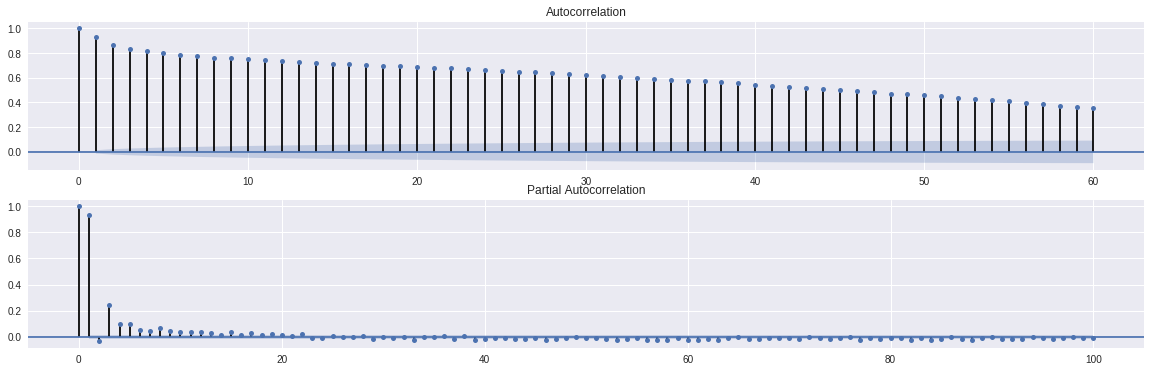

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, figsize=(20,6))
fig1 = plot_acf(scaled_data,lags = 60, ax = axes[0])
fig2 = plot_pacf(scaled_data, lags = 100, ax = axes[1])
plt.show()

# Network Architecture and Model fitting 

In [80]:
from keras.layers.advanced_activations import *
from keras.regularizers import l1, l2 
from sklearn.metrics import r2_score
import keras.backend as K
from keras.layers import ConvLSTM2D
np.random.seed(1977)

inputs = Input(shape = (trainX.shape[1], trainX.shape[-1]))


x = Conv1D(filters = 32, kernel_size = 3, padding = "causal", dilation_rate = 2, activation = "relu")(inputs)


y = Conv1D(filters = 32, kernel_size = 3, padding = "causal", dilation_rate = 4, activation = "relu")(inputs)


z = Conv1D(filters = 32, kernel_size = 3, padding = "causal", dilation_rate = 6, activation = "relu")(inputs)


u = Conv1D(filters = 32, kernel_size = 3, padding = "causal", dilation_rate = 8, activation = "relu")(inputs)


v = Conv1D(filters = 32, kernel_size = 3, padding = "causal", dilation_rate = 16, activation = "relu")(inputs)

x = concatenate([inputs, x, y, z, u, v], axis = -1)
#x = Bidirectional(LSTM(10, activation = "relu", kernel_initializer = "he_normal", dropout = 0.1, recurrent_dropout = 0.1, return_sequences = True))(x)
#x = Bidirectional(LSTM(10, activation = "relu", kernel_initializer = "he_normal", dropout = 0.1, recurrent_dropout = 0.1))(x)

x = Dropout(0.1)(x)
x = TimeDistributed(Dense(64, activation = "tanh", kernel_initializer = "he_normal"))(x)
                          #kernel_regularizer = l2(1e-3)))(x)
  
 
x = Flatten()(x)
x = Dropout(0.1)(x)
predictions = Dense(1, activation = "tanh", kernel_initializer = "he_normal")(x)



model = Model(inputs = inputs, outputs = predictions)
opt = adam(lr = 1e-3, clipnorm = 1.)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience = 3, min_lr = 1e-5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = "timeseries_weights.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'val_loss', min_delta = 1e-5, patience = 30, verbose = 1)

model.compile(optimizer=opt, loss='mse', metrics = [])
model.summary()

history = model.fit(trainX, trainY, 
          epochs = 20, 
          batch_size = 128, 
          verbose = 1, 
          validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 20, 15)       0                                            
__________________________________________________________________________________________________
conv1d_71 (Conv1D)              (None, 20, 32)       1472        input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_72 (Conv1D)              (None, 20, 32)       1472        input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_73 (Conv1D)              (None, 20, 32)       1472        input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_74 

In [0]:
preds = model.predict(testX, batch_size = 1)


Final R2 Score is: 0.9299577282761994


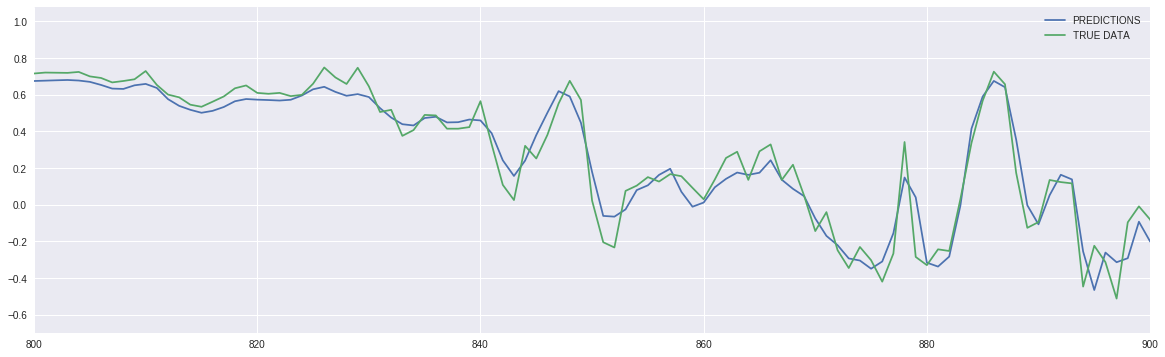

In [83]:
print("Final R2 Score is: {}".format(r2_score(testY, preds)))

fig = plt.figure(figsize = (20,6))
fig = plt.plot(preds, label = "PREDICTIONS")
fig = plt.plot(testY, label = "TRUE DATA")
plt.xlim([800,900])
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()